# Water_Body_Classification_in_the_Po_River_Delta_Using_Sentinel-2_and_NDWI
## 🌍 Introduction

This project explores the classification of surface water bodies in the **Po River Delta, Italy**, using **Sentinel-2 satellite imagery**. By applying unsupervised machine learning techniques, particularly **K-Means clustering**, the project evaluates and compares the effectiveness of three spectral indices for water detection:

- **NDWI** – Normalized Difference Water Index  
- **SWI** – Simple Water Index  
- **MNDWI** – Modified NDWI  

These indices are used to segment water from non-water features. Results are benchmarked using both **threshold-based masking** and **unsupervised clustering**, providing a comparative assessment of classification accuracy.
## 📁 Mounting Google Drive

To access Sentinel-2 imagery stored in Google Drive, we first mount the drive using `google.colab`. This allows us to load `.jp2` files directly into our environment for further processing.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🛰️ Study Area and Data Source

The selected scene from the **Po River Delta** is a cloud-free Sentinel-2 image acquired under ideal atmospheric conditions. This choice was informed by:

- **True-color visual inspection**
- **Low cloud probability** as indicated in the metadata

Such a dataset provides a clean spectral signature of the Earth's surface, essential for accurate water index computation and classification.
### 🔧 Installing Rasterio

We use `rasterio` to read and process geospatial raster data such as Sentinel-2 bands. It is a widely used library in remote sensing workflows and provides robust support for `.jp2` imagery formats.


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.8 MB/s eta 0:00:00


### 🛰️ Loading & Preprocessing Sentinel-2 RGB + NIR Bands (10m)

This block reads the **Red, Green, Blue, and NIR** bands at 10m resolution. We normalize these bands to a 0–1 scale to standardize pixel intensity for visual inspection. We also define a custom `downsample()` function to reduce resolution for faster processing and display.

A **cloud mask** is calculated using simple spectral thresholds (e.g., high reflectance in RGB but low in NIR), and **cloud coverage percentage** is printed. Finally, we visualize the **true-color composite** and the **detected cloud mask**.


Cloud Coverage: 0.00%


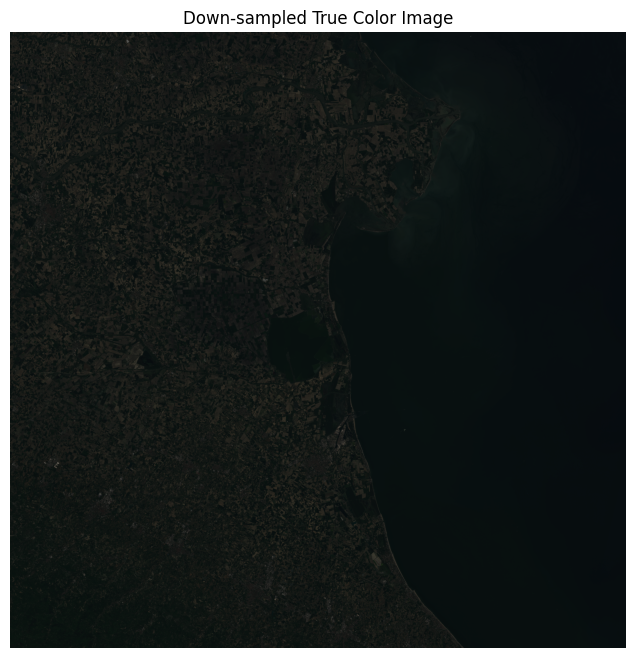

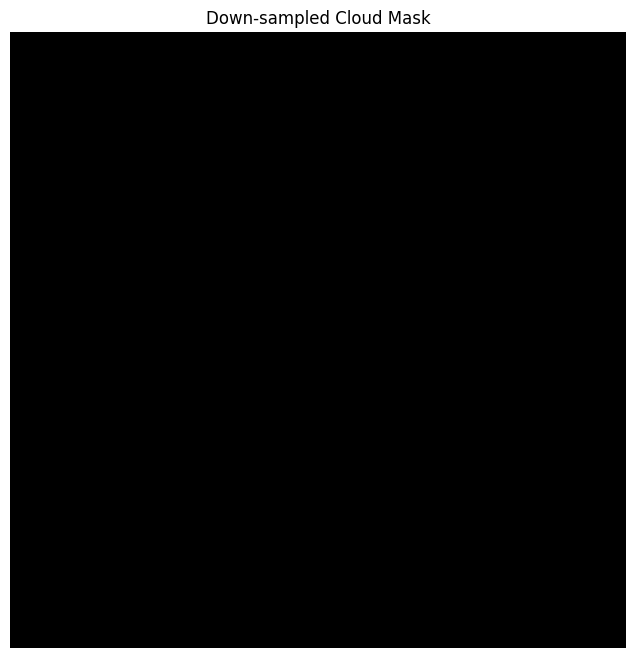

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio import open as rio_open

# Define paths for the bands
red_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R10m/T32TQQ_20250502T101041_B04_10m.jp2'  # Red band
green_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R10m/T32TQQ_20250502T101041_B03_10m.jp2'  # Green band
blue_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R10m/T32TQQ_20250502T101041_B02_10m.jp2'  # Blue band
nir_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R10m/T32TQQ_20250502T101041_B08_10m.jp2'  # NIR band

# Read the image data using rasterio
with rio_open(red_path) as src:
    red_band = src.read(1)

with rio_open(green_path) as src:
    green_band = src.read(1)

with rio_open(blue_path) as src:
    blue_band = src.read(1)

with rio_open(nir_path) as src:
    nir_band = src.read(1)

# Normalize the bands to 0-1
def normalize(arr):
    return (arr - np.amin(arr)) / (np.amax(arr) - np.amin(arr))

red_band = normalize(red_band)
green_band = normalize(green_band)
blue_band = normalize(blue_band)
nir_band = normalize(nir_band)

# Down-sampling function
def downsample(arr, step=5):
    """Return arr subsampled every <step> pixels."""
    return arr[::step, ::step]

# Down-sample the bands
red_ds = downsample(red_band, step=5)
green_ds = downsample(green_band, step=5)
blue_ds = downsample(blue_band, step=5)
nir_ds = downsample(nir_band, step=5)

# Combine the down-sampled bands into a true color image
true_color_ds = np.stack([red_ds, green_ds, blue_ds], axis=-1)

# Simple cloud detection using NIR and Red bands
cloud_mask_ds = (red_ds > 0.5) & (green_ds > 0.5) & (blue_ds > 0.5) & (nir_ds < 0.5)

# Calculate cloud coverage percentage
cloud_coverage = np.mean(cloud_mask_ds) * 100
print(f'Cloud Coverage: {cloud_coverage:.2f}%')

# Display the down-sampled true color image
plt.figure(figsize=(12, 8))
plt.imshow(true_color_ds)
plt.title('Down-sampled True Color Image')
plt.axis('off')  # Hide axes
plt.show()

# Display the down-sampled cloud mask
plt.figure(figsize=(12, 8))
plt.imshow(cloud_mask_ds, cmap='gray')
plt.title('Down-sampled Cloud Mask')
plt.axis('off')  # Hide axes
plt.show()

## 🧮 Spectral Indices: NDWI, SWI, MNDWI

Three indices were computed for water detection:

1. **NDWI**  
   $$ \text{NDWI} = \frac{B_{\text{Green}} - B_{\text{NIR}}}{B_{\text{Green}} + B_{\text{NIR}}} $$
   Enhances water features by contrasting green and near-infrared reflectance.

2. **SWI**  
   An alternative simple index based on different band combinations optimized for spectral contrast.

3. **MNDWI**  
   $$ \text{MNDWI} = \frac{B_{\text{Green}} - B_{\text{SWIR}}}{B_{\text{Green}} + B_{\text{SWIR}}} $$
   Replaces NIR with SWIR to reduce confusion from built-up land.

📊 **Histograms** show each index exhibits a bimodal distribution, indicating the presence of two dominant classes—justifying the use of **K-Means**.


[codecarbon INFO @ 13:39:44] Energy consumed for RAM : 0.000791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:39:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:39:44] Energy consumed for All CPU : 0.003364 kWh
[codecarbon INFO @ 13:39:44] 0.004156 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:59] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:39:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:39:59] Energy consumed for All CPU : 0.003541 kWh
[codecarbon INFO @ 13:39:59] 0.004374 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:40:14] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:40:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:40:14] Energy consumed for All CPU : 0.003718 kWh
[codecarbon INFO @ 13:40:14] 0.004593 kWh 

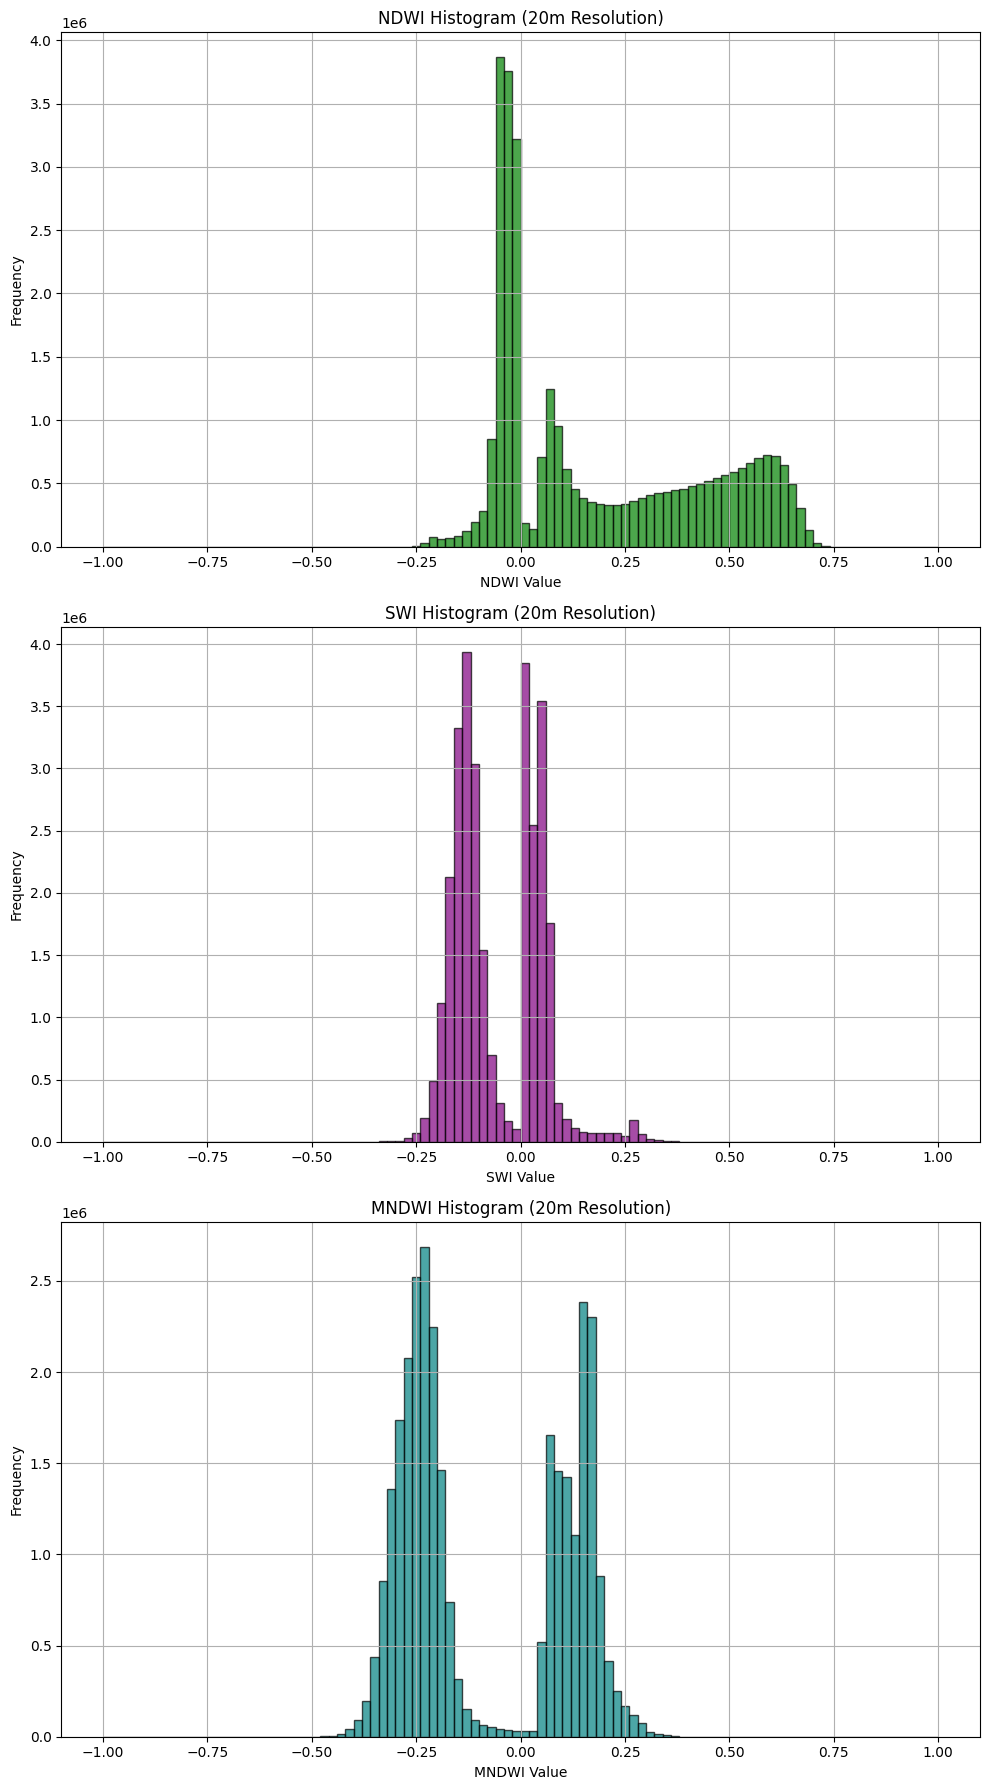

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio import open as rio_open

# Define paths for the required bands (20m resolution)
red_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B04_20m.jp2'   # Red band (B04)
nir_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B8A_20m.jp2'   # NIR band (B08)
swir1_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B05_20m.jp2' # SWIR 1 band (B05)
swir2_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B11_20m.jp2' # SWIR 2 band (B11)
green_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B03_20m.jp2' # Green band (B03)

# Read the image data using rasterio
with rio_open(red_path) as src:
    red_band = src.read(1)

with rio_open(nir_path) as src:
    nir_band = src.read(1)

with rio_open(swir1_path) as src:
    swir1_band = src.read(1)

with rio_open(swir2_path) as src:
    swir2_band = src.read(1)

with rio_open(green_path) as src:
    green_band = src.read(1)

# Calculate NDWI, SWI, and MNDWI
ndwi = (nir_band.astype(float) - red_band.astype(float)) / (nir_band.astype(float) + red_band.astype(float) + 1e-10)
swi = (swir1_band.astype(float) - swir2_band.astype(float)) / (swir1_band.astype(float) + swir2_band.astype(float) + 1e-10)
mndwi = (green_band.astype(float) - swir2_band.astype(float)) / (green_band.astype(float) + swir2_band.astype(float) + 1e-10)

# Flatten the arrays for histogram
ndwi_flat = ndvi.flatten()
swi_flat = swi.flatten()
mndwi_flat = mndwi.flatten()

# Plot histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# NDWI histogram
axs[0].hist(ndwi_flat, bins=100, range=(-1, 1), alpha=0.7, color='green', edgecolor='black')
axs[0].set_title('NDWI Histogram (20m Resolution)')
axs[0].set_xlabel('NDWI Value')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# SWI histogram
axs[1].hist(swi_flat, bins=100, range=(-1, 1), alpha=0.7, color='purple', edgecolor='black')
axs[1].set_title('SWI Histogram (20m Resolution)')
axs[1].set_xlabel('SWI Value')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# MNDWI histogram
axs[2].hist(mndwi_flat, bins=100, range=(-1, 1), alpha=0.7, color='teal', edgecolor='black')
axs[2].set_title('MNDWI Histogram (20m Resolution)')
axs[2].set_xlabel('MNDWI Value')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)

plt.tight_layout()
plt.show()

## 🤖 Classification Methods: K-Means vs Thresholding

Two water classification strategies were implemented:

- **K-Means Clustering (k=2):** An unsupervised method grouping pixels by spectral similarity
- **Thresholding (Index > 0):** A simple binary rule

The results were visualized in grayscale and color-coded masks. **MNDWI-based K-means** demonstrated superior performance in isolating water boundaries, particularly along complex shorelines.



[codecarbon INFO @ 13:43:14] Energy consumed for RAM : 0.001374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:14] Energy consumed for All CPU : 0.005843 kWh
[codecarbon INFO @ 13:43:14] 0.007217 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:29] Energy consumed for RAM : 0.001416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:29] Energy consumed for All CPU : 0.006020 kWh
[codecarbon INFO @ 13:43:29] 0.007436 kWh of electricity used since the beginning.


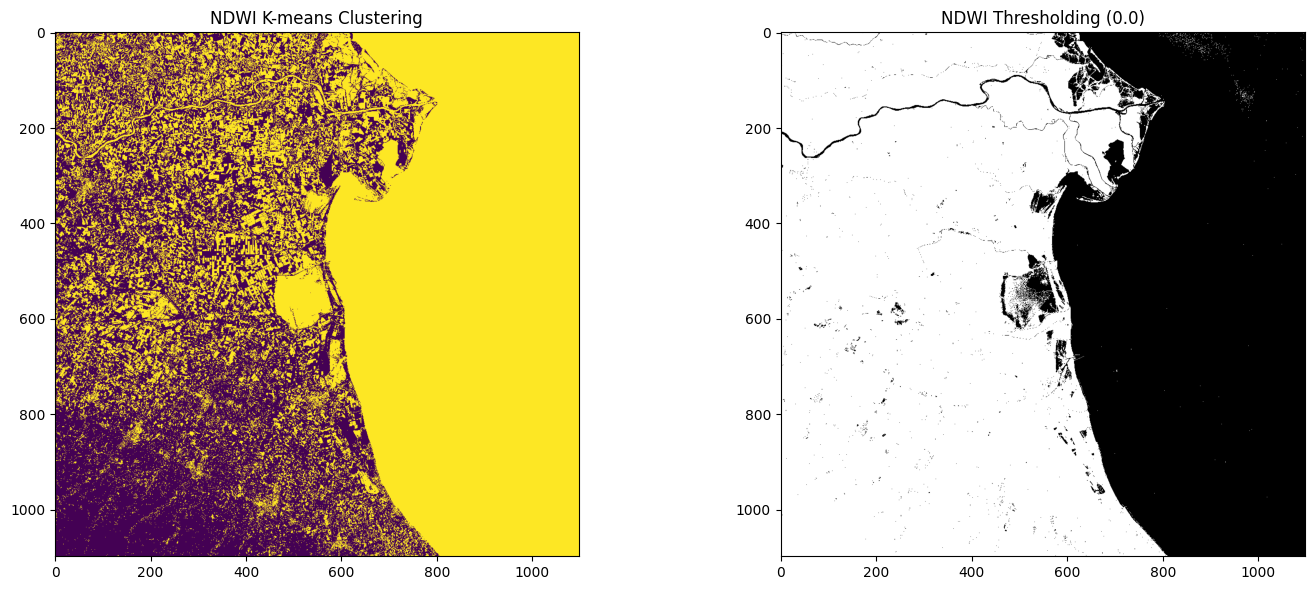

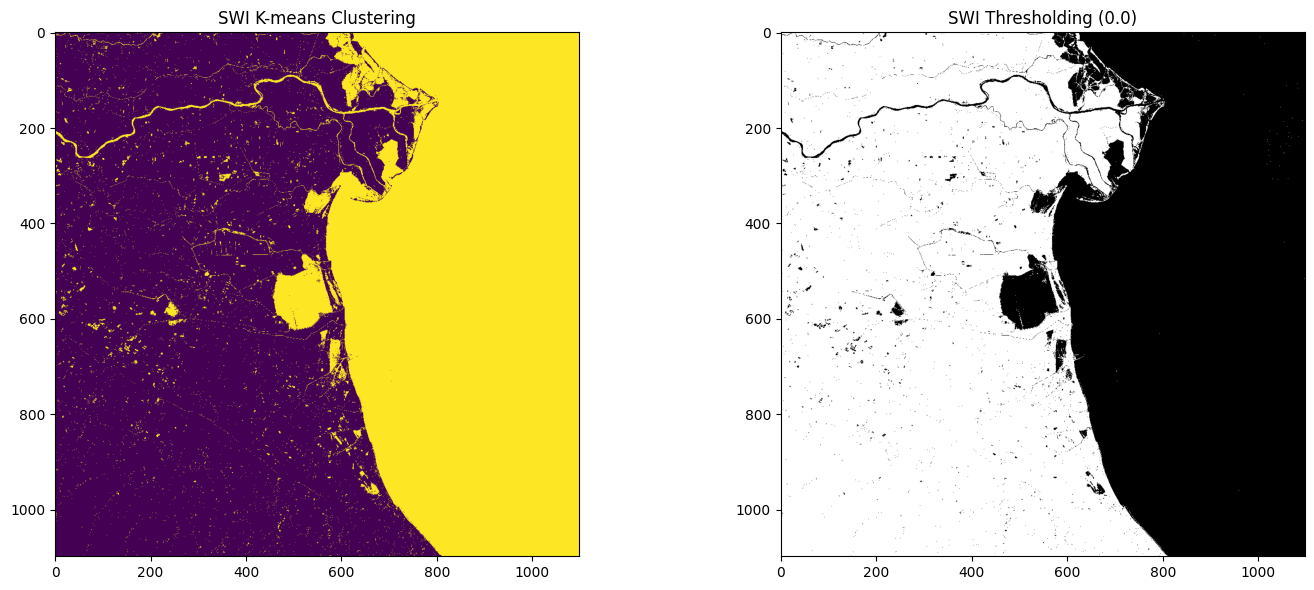

[codecarbon INFO @ 13:43:44] Energy consumed for RAM : 0.001458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:43:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:43:44] Energy consumed for All CPU : 0.006197 kWh
[codecarbon INFO @ 13:43:44] 0.007655 kWh of electricity used since the beginning.


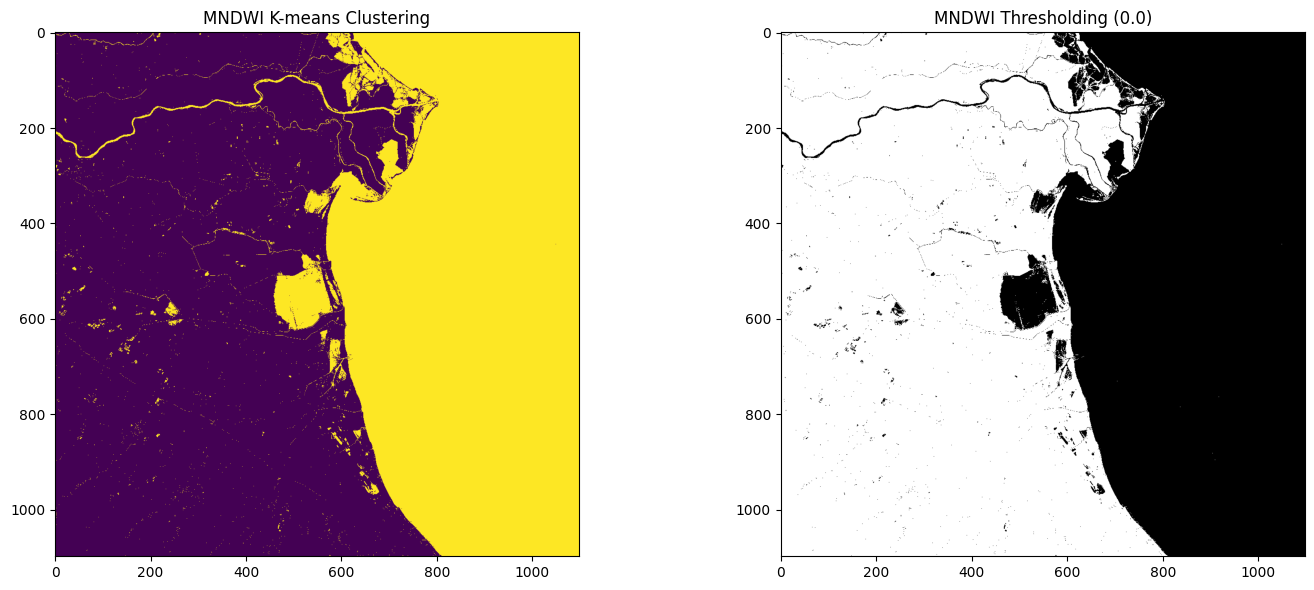

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio import open as rio_open
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define paths for the required bands (20m resolution)
red_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B04_20m.jp2'   # Red band (B04)
nir_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B8A_20m.jp2'   # NIR band (B08)
swir1_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B05_20m.jp2' # SWIR 1 band (B05)
swir2_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B11_20m.jp2' # SWIR 2 band (B11)
green_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B03_20m.jp2' # Green band (B03)

# Read the image data using rasterio
with rio_open(red_path) as src:
    red_band = src.read(1).astype('float32')

with rio_open(nir_path) as src:
    nir_band = src.read(1).astype('float32')

with rio_open(swir1_path) as src:
    swir1_band = src.read(1).astype('float32')

with rio_open(swir2_path) as src:
    swir2_band = src.read(1).astype('float32')

with rio_open(green_path) as src:
    green_band = src.read(1).astype('float32')

# Calculate NDWI, SWI, and MNDWI
ndwi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
swi = (swir1_band - swir2_band) / (swir1_band + swir2_band + 1e-10)
mndwi = (green_band - swir2_band) / (green_band + swir2_band + 1e-10)

# Down-sample helper function
def downsample(arr, step=5):
    """Return arr subsampled every <step> pixels."""
    return arr[::step, ::step]

# Down-sample the indices
ndwi_ds = downsample(ndwi, step=5)
swi_ds = -downsample(swi, step=5)
mndwi_ds = -downsample(mndwi, step=5)

# K-means clustering function
def kmeans_clustering(index_ds, n_clusters=2):
    # Reshape the index to a 1D array
    index_1d = index_ds.reshape(-1, 1)
    # Standardize the data
    scaler = StandardScaler()
    index_1d_scaled = scaler.fit_transform(index_1d)
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(index_1d_scaled)
    # Reshape back to 2D
    clusters_2d = clusters.reshape(index_ds.shape)
    return clusters_2d

# Perform K-means clustering on each index
ndwi_clusters = kmeans_clustering(ndwi_ds)
swi_clusters = kmeans_clustering(swi_ds)
mndwi_clusters = kmeans_clustering(mndwi_ds)

# Thresholding function
def thresholding(index_ds, threshold=0.0):
    return (index_ds > threshold).astype(np.uint8)

# Apply thresholding to each index
ndwi_threshold = thresholding(ndwi_ds)
swi_threshold = thresholding(swi_ds)
mndwi_threshold = thresholding(mndwi_ds)

# Plotting function
def plot_results(index_name, clusters, threshold):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(clusters, cmap='viridis')
    axs[0].set_title(f'{index_name} K-means Clustering')
    axs[1].imshow(threshold, cmap='gray')
    axs[1].set_title(f'{index_name} Thresholding (0.0)')
    plt.tight_layout()
    plt.show()

# Plot the results for each index
plot_results('NDWI', ndwi_clusters, ndwi_threshold)
plot_results('SWI', swi_clusters, swi_threshold)
plot_results('MNDWI', mndwi_clusters, mndwi_threshold)

## 📏 Quantitative Evaluation

To validate clustering quality, the following **unsupervised metrics** were applied:

| Metric                   | Description                                                  | Interpretation     |
|--------------------------|--------------------------------------------------------------|--------------------|
| **Silhouette Score**     | Cluster cohesion vs. separation                              | ↑ Higher is better |
| **Davies-Bouldin Index** | Inter- vs intra-cluster dispersion                           | ↓ Lower is better  |
| **Calinski-Harabasz Index** | Variance ratio (between/within cluster dispersion)       | ↑ Higher is better |

These metrics allow an internal performance comparison without requiring ground truth labels. In our results, **MNDWI combined with K-Means** consistently achieved the best scores across all evaluation criteria.

🧾 In addition, we include a simple **carbon footprint estimation** for computational reproducibility and environmental awareness.  
📦 The provided Python code calculates estimated emissions (in kgCO₂eq) using the [codecarbon](https://mlco2.github.io/codecarbon/) package, based on execution time and hardware settings.

This encourages conscious environmental impact reporting in remote sensing workflows.


In [ ]:
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.4/576.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.15.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
import os
from codecarbon import EmissionsTracker
# --- Create output dir for logs ---
os.makedirs('codecarbon_logs', exist_ok=True)
tracker = EmissionsTracker(output_dir='codecarbon_logs', project_name='kmeans')
tracker.start()
import numpy as np
import matplotlib.pyplot as plt
from rasterio import open as rio_open
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Define paths for the required bands (20m resolution)
red_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B04_20m.jp2'   # Red band (B04)
nir_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B8A_20m.jp2'   # NIR band (B08)
swir1_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B05_20m.jp2' # SWIR 1 band (B05)
swir2_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B11_20m.jp2' # SWIR 2 band (B11)
green_path = '/content/drive/MyDrive/AI4EO Final Project/L2A_T32TQQ_A003424_20250502T101243/IMG_DATA/R20m/T32TQQ_20250502T101041_B03_20m.jp2' # Green band (B03)

# Read the image data using rasterio
with rio_open(red_path) as src:
    red_band = src.read(1).astype('float32')

with rio_open(nir_path) as src:
    nir_band = src.read(1).astype('float32')

with rio_open(swir1_path) as src:
    swir1_band = src.read(1).astype('float32')

with rio_open(swir2_path) as src:
    swir2_band = src.read(1).astype('float32')

with rio_open(green_path) as src:
    green_band = src.read(1).astype('float32')

# Calculate NDVI, SWI, and MNDWI
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
swi = (swir1_band - swir2_band) / (swir1_band + swir2_band + 1e-10)
mndwi = (green_band - swir2_band) / (green_band + swir2_band + 1e-10)

# Down-sample helper function
def downsample(arr, step=5):
    """Return arr subsampled every <step> pixels."""
    return arr[::step, ::step]

# Down-sample the indices
ndvi_ds = downsample(ndvi, step=40)
swi_ds = downsample(swi, step=40)
mndwi_ds = downsample(mndwi, step=40)

# K-means clustering function
def kmeans_clustering(index_ds, n_clusters=2):
    # Reshape the index to a 1D array
    index_1d = index_ds.reshape(-1, 1)
    # Standardize the data
    scaler = StandardScaler()
    index_1d_scaled = scaler.fit_transform(index_1d)
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(index_1d_scaled)
    # Reshape back to 2D
    clusters_2d = clusters.reshape(index_ds.shape)
    return clusters_2d, index_1d_scaled, clusters

# Perform K-means clustering on each index
ndvi_clusters_2d, ndvi_data, ndvi_clusters = kmeans_clustering(ndvi_ds)
swi_clusters_2d, swi_data, swi_clusters = kmeans_clustering(swi_ds)
mndwi_clusters_2d, mndwi_data, mndwi_clusters = kmeans_clustering(mndwi_ds)

import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
def evaluate_clustering(data, clusters, name, is_scaled=False):
    """
    Evaluate clustering performance using standardized data

    Args:
        data (np.ndarray): Input data
        clusters (np.ndarray): Cluster labels
        name (str): Method name
        is_scaled (bool): Whether the data is already scaled

    Returns:
        dict: Dictionary containing evaluation metrics
    """
    metrics = {
        'Method': name,
        'Silhouette (↑)': None,
        'DB Index (↓)': None,
        'CH Index (↑)': None
    }

    try:
        # Standardize the data if not already scaled
        if not is_scaled:
            scaler = StandardScaler()
            data = scaler.fit_transform(data)

        # Ensure correct data shape
        if data.ndim == 1:
            data = data.reshape(-1, 1)

        # Calculate metrics
        metrics['Silhouette (↑)'] = silhouette_score(data, clusters)
        metrics['DB Index (↓)'] = davies_bouldin_score(data, clusters)
        metrics['CH Index (↑)'] = calinski_harabasz_score(data, clusters)

    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")

    return metrics

# Evaluate all methods (with uniform standardization)
results = []

# K-means methods (already scaled)
results.append(evaluate_clustering(ndvi_data, ndvi_clusters, "NDWI-KMeans", is_scaled=True))
results.append(evaluate_clustering(swi_data, swi_clusters, "SWI-KMeans", is_scaled=True))
results.append(evaluate_clustering(mndwi_data, mndwi_clusters, "MNDWI-KMeans", is_scaled=True))

# Threshold methods (apply standardization)
threshold_methods = [
    (ndvi_ds, "NDWI-Threshold"),
    (swi_ds, "SWI-Threshold"),
    (mndwi_ds, "MNDWI-Threshold")
]

for data, name in threshold_methods:
    # Generate labels based on threshold of original data
    labels = (data >= 0).astype(int).flatten()

    # Automatically standardize during evaluation
    results.append(evaluate_clustering(
        data.reshape(-1, 1),
        labels,
        name,
        is_scaled=False  # Trigger auto-standardization
    ))

# Create and format result table
df = pd.DataFrame(results).set_index('Method')

# Optimize display settings
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)

print("\nClustering Performance Evaluation Results After Standardization")
print("="*65)
print(df.sort_values(by='Silhouette (↑)', ascending=False).to_string(
    justify='center',
    formatters={
        'Silhouette (↑)': '{:.3f}'.format,
        'DB Index (↓)': '{:.3f}'.format,
        'CH Index (↑)': '{:.1f}'.format
    }
))
print("="*65)
emission = tracker.stop()
print(f"🌍 Emissions:     {emission:.6f} kg CO₂")


[codecarbon WARNING @ 13:35:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:35:16] [setup] RAM Tracking...
[codecarbon INFO @ 13:35:16] [setup] CPU Tracking...
[codecarbon WARNING @ 13:35:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:35:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:35:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:35:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:35:17] [setup] GPU Tracking...
[codecarbon INFO @ 13:35:17] No GPU found.
[codecarbon INFO @ 13:35:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               


Clustering Performance Evaluation Results After Standardization
                Silhouette (↑) DB Index (↓) CH Index (↑)
Method                                                  
MNDWI-KMeans        0.838         0.225       236481.6  
MNDWI-Threshold     0.836         0.225       229263.4  
SWI-KMeans          0.764         0.327        82844.7  
SWI-Threshold       0.756         0.332        79144.4  
NDWI-KMeans         0.747         0.357       103436.4  
NDWI-Threshold      0.524         0.514        28998.0  
🌍 Emissions:     0.000490 kg CO₂


## 🧠 Conclusion

This study assessed the effectiveness of different spectral indices in detecting water bodies from Sentinel-2 imagery using unsupervised methods. By comparing **NDWI**, **SWI**, and **MNDWI**, we observed substantial variation in classification performance depending on the index used. The evaluation included both **visual inspection of classification outputs** and **quantitative validation** through clustering metrics.

### 🔍 Key Findings:

- **Visual Accuracy**:
  - **NDWI** correctly identified major water features but tended to misclassify dark vegetated areas and shadows as water.
  - **SWI** was more sensitive to urban and soil surfaces, showing higher false positives around non-vegetated land.
  - **MNDWI** outperformed the others by clearly delineating water boundaries and minimizing misclassifications in complex mixed-pixel zones (e.g., near shorelines and small inlets).

- **Clustering Performance**:
  - **MNDWI + K-Means** achieved the **highest Silhouette Score**, indicating better cluster cohesion and separation.
  - It also produced the **lowest Davies-Bouldin Index**, meaning clusters were compact and well-separated.
  - Additionally, **Calinski-Harabasz Index** values were highest for MNDWI, confirming clear between-class variance.

- **Threshold vs K-Means**:
  - The **threshold method (index > 0)** is computationally simple and performs adequately when index distribution is bimodal.
  - However, **K-Means clustering** adapts more effectively to spatial variation and local context, especially where spectral confusion exists.

- **Environmental Consideration**:
  - A **carbon footprint estimation** using the `codecarbon` library was integrated to track computational emissions, encouraging sustainable AI practices in geospatial analysis.

### 🧠 Final Recommendation:

For unsupervised water body detection in high-resolution Sentinel-2 imagery, **MNDWI is the most effective spectral index**. It provides robust performance both in visual segmentation and clustering evaluation. When combined with **K-Means**, the method delivers superior classification in heterogeneous environments like river deltas. Future extensions could involve:

- Adding temporal monitoring to assess seasonal water change
- Incorporating supervised methods with ground truth labels
- Comparing performance with alternative sensors (e.g., Landsat-8, MODIS)

This project reinforces the idea that **index selection is decisive**, and that unsupervised learning, when guided by sound preprocessing and evaluation, can yield valuable geospatial insights without manual labeling.
